In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

### Leaky-integrate-and-fire Neuron Model

In [2]:
def lif(p):

    tau = p[0]
    R = p[1]
    I = 1
    dt = 0.01
    deltaT = 4
    VT = -50
    E = -70
    VspikeThreshold = -20
    Vreset = -70

    V = np.zeros((10000)); V[0] = -70
    W = np.zeros((10000)); W[0] = 100

    spikeTimes = []

    for nn in range(10000-1):
        dV = (E - V[nn] + deltaT*np.exp((V[nn]-VT)/deltaT) + R*I)/tau * dt
        V[nn+1] = (V[nn] + dV)
        if V[nn+1] > VspikeThreshold:
            V[nn+1] = Vreset
            spikeTimes.append(nn*dt)
    return V, spikeTimes

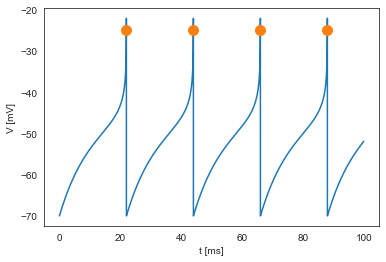

In [3]:
# We generate a baseline neuron
tau = 10
R = 25
V_base, spikeTimes_base = lif([tau, R])

t = np.arange(0, 100, 0.01)
plt.plot(t, V_base)
plt.plot(spikeTimes_base, np.repeat(-25, len(spikeTimes_base)), '.', markersize=20)
plt.xlabel("t [ms]")
plt.ylabel("V [mV]")
plt.savefig("neuron_model_baseline.png")

### Evaluation function
We need an evaluation function for our genetic algorithm. Here we compare the absolute difference between our baseline neuron and the neuron modelled with the current parameters during our optimization process. "individual" is a list with the two parameters "tau" and "R".  
Keep in mind that we want to minimize the error between the two time series. The error is defined as the absolut difference between the two time series. This simple measure is applicable for all time series and could also be used for other use cases beside optimizing neuron models.  
I will show another approach featuring spike trains below.

In [4]:
def evalFunc(individual, V=None):
    V_tmp, _ = lif(individual)
    error = float(np.sum(np.abs(V_tmp - V) / 10000))
    return (error,)

### Genetic Algorithm setup
We setup a really basic optimization routine with the gaSimple() function of DEAP.
As mentioned above we want to minimize the error between our baseline model and the model with the parameters to optimize. For this reason we have to minimize the fitness, which requires negative weights:

'''
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
'''

Furthermore, we initilize our individuals with integers between [0, 100]. This can of course also be done with floats.

In [5]:
import array
import random

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Attribute generator
toolbox.register("attr_int", random.randint, 0, 50)

# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evalFunc, V=V_base)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

random.seed(64)

pop = toolbox.population(n=300)
hof = tools.HallOfFame(10)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

#### Run the optimization

In [6]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, 
                                stats=stats, halloffame=hof, verbose=True)

C:\Users\Alex\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


gen	nevals	avg    	std    	min    	max   
0  	300   	9.83727	2.38124	1.86038	15.864
1  	169   	8.40574	1.88541	0      	15.864
2  	190   	7.555  	1.93199	0      	15.864
3  	179   	6.86526	2.52256	0      	15.864
4  	185   	6.25684	2.84475	0      	15.864
5  	179   	5.37311	3.14698	0      	15.864
6  	175   	5.15109	3.50057	0      	15.864
7  	176   	5.08701	3.42536	0      	15.864
8  	192   	4.86223	3.79485	0      	15.864
9  	163   	3.92105	3.94828	0      	15.864
10 	180   	2.78031	3.80371	0      	15.864


#### Examine the results

[Individual('i', [10, 25]), Individual('i', [26, 48]), Individual('i', [21, 41]), Individual('i', [5, 19]), Individual('i', [6, 20]), Individual('i', [21, 40]), Individual('i', [9, 24]), Individual('i', [8, 22]), Individual('i', [10, 19]), Individual('i', [8, 23])]
array('i', [10, 25])


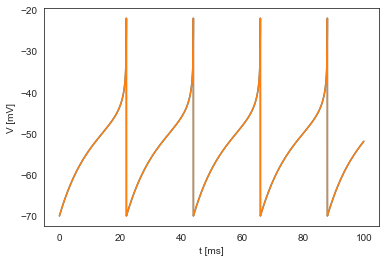

In [7]:
print(hof)

V_opt, _ = lif(hof[0][:])
print(hof[0][:])
t = np.arange(0, 100, 0.01)
plt.plot(t, V_base)
plt.plot(t, V_opt)
plt.xlabel("t [ms]")
plt.ylabel("V [mV]")
plt.savefig("neuron_model_result.png")

#### Optimization with Spike Trains

First we create a new evaluation function. We will use the "pyspike" package to calculate the ISI-distance measure. The ISI-distance is the integral over the isi distance profile.

In [13]:
from pyspike import SpikeTrain, isi_distance

def evalFuncSpikeTrains(individual, V=None, spikeTimes_base=None):
    V_tmp, spikeTimes_opt = lif(individual)
    spikeTrain_base = SpikeTrain(spikeTimes_base, (0.0, 100))
    spikeTrain_opt = SpikeTrain(spikeTimes_opt, (0.0, 100))
    error = isi_distance(spikeTrain_base, spikeTrain_opt)
    return (error,)

In [14]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Attribute generator
toolbox.register("attr_int", random.randint, 0, 50)

# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evalFuncSpikeTrains, V=V_base, spikeTimes_base=spikeTimes_base)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

random.seed(64)

pop = toolbox.population(n=300)
hof = tools.HallOfFame(10)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [15]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, 
                                stats=stats, halloffame=hof, verbose=True)

C:\Users\Alex\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


gen	nevals	avg     	std    	min       	max     
0  	300   	0.589789	0.24171	0.00632054	0.999546
1  	169   	0.423639	0.236751	0         	0.999546
2  	190   	0.301678	0.218075	0         	0.999546
3  	179   	0.252442	0.233948	0         	0.999546
4  	185   	0.207415	0.232576	0         	0.999546
5  	179   	0.203355	0.254384	0         	0.999546
6  	175   	0.187591	0.258528	0         	0.999546
7  	176   	0.161834	0.235718	0         	0.999546
8  	192   	0.167157	0.246953	0         	0.999546
9  	163   	0.162855	0.243213	0         	0.999546
10 	180   	0.174503	0.256763	0         	0.999546


We are able to find the correct parameters.

[Individual('i', [10, 25]), Individual('i', [26, 48]), Individual('i', [23, 44]), Individual('i', [21, 41]), Individual('i', [23, 43]), Individual('i', [21, 40]), Individual('i', [9, 24]), Individual('i', [22, 43]), Individual('i', [26, 47]), Individual('i', [22, 41])]
array('i', [10, 25])


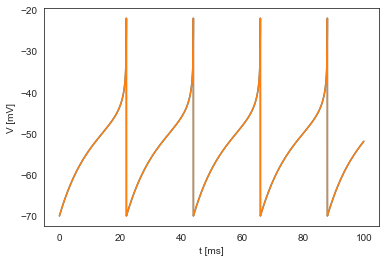

In [16]:
print(hof)

V_opt, _ = lif(hof[0][:])
print(hof[0][:])
t = np.arange(0, 100, 0.01)
plt.plot(t, V_base)
plt.plot(t, V_opt)
plt.xlabel("t [ms]")
plt.ylabel("V [mV]")
plt.savefig("neuron_model_result.png")